# Geodatenanalyse 1

## Übung 10: Sensitivitätsanalyse - Lösung

### Aufgabe 1: Contribution-to-Variance

Als Anwendungsbeispiel für eine Sensitivitätsanalyse werden wir das Model und die Unsicherheitsanalyse aus der letzten Übung verwenden. Kopiert daher zuerst das Skript mit der MC Simulation in dieses Notebook, damit ihr alle Input- und Outputwerte als Variablen zur Verfügung habt. 

In [1]:
# [1]
# Monte-Carlo Simulation zur Bestimmung der Abbaurate von O-Xylol
import numpy as np
from scipy.stats import truncnorm
import matplotlib.pyplot as plt

n = 5000 # number of MC simulations 

# input data 
# isotope shift delta 13C [o/oo], truncated to (3.8, 4.8)
a, b = (3.8 - 4.3) / 0.7, (4.8 - 4.3) / 0.7
deltaC = truncnorm.rvs(a, b, 4.3, 0.7, size=n)
# isotope enrichment factor epsilon [-]
epsilon = np.random.uniform(-3.2, -1.1, n)
# distance [m]
s = np.random.uniform(415, 423, n)
# effective porosity [-], trunctaed to (0.12, 0.30)
a, b = (0.12 - 0.21) / 0.9, (0.3 - 0.21) / 0.9
neff = truncnorm.rvs(a, b, 0.21, 0.9, size=n)
# time, truncated to (3e8, 3.3e8)
a, b = (3e8 - 3.15e8) / 1.6e6, (3.3e8 - 3.15e8) / 1.6e6
t = truncnorm.rvs(a, b, 3.15e8, 1.6e6, size=n)
# hydraulic gradient [-]
grad = np.random.uniform(1.3e-3, 1.6e-3, n)

kf =np.zeros(n)
lambda_rate = np.zeros(n)
# analytical model
for i in range(n):
    kf[i] = (s[i]*neff[i])/(t[i]*grad[i])
    lambda_rate[i] = -(deltaC[i]*kf[i]*grad[i])/(epsilon[i]*s[i]*neff[i])

lambda_rate = lambda_rate*3600*24*365 # to get values as [1/a]

Für die Contribution-to-Variance Analyse und die Berechnung von Kovarianzen und Korrelationen ist es praktisch, alle benötigten Werte in einem Pandas DataFrame zusammenzufassen, um sicherzustellen, dass die Dimensionen, Ausrichtung von Spalten usw. alle stimmen. 

Das Generieren eines DataFrame erfolgt über die Funktion `pandas.DataFrame()`, mit dem Syntax: "data = pd.DataFrame({'column_name': column_value, ...})". Die Spalten und Namen könnt Ihr aus dem Output des Monte Carlo Codes zusammensetzen. 

Berechnet anschließend die Kovarianzen (`data.cov()`) und Korrelationen nach Pearson (`data.corr()`) für den DataFrame. Welches Maß macht hier mehr Sinn für eine Betrachtung der Sensitivitäten? 

In [2]:
# [2] 
# pandas package importieren
import pandas as pd

# DataFrame generieren
data = pd.DataFrame({'lambda_rate': lambda_rate, 'kf': kf, 'deltaC': deltaC, 'epsilon': epsilon, 's':s,
                     'neff': neff, 't': t, 'grad': grad})

# Kovarianzen und Korrelation berechnen
covariance = data.cov()
correlation = data.corr()

Stellt nun die Ergebnisse für die Sensitivitätsanalyse, sowohl für den kf-Wert als auch die Abbaurate mit Hilfe der Funktion `subplot` in `matplotlib` graphisch in einem Tornadoplot dar. Am einfachsten geht das über ein horizontales Balkendiagramm mit `matplotlib.pyplot.barh()`. 

Überlegt Euch auch genau welche Werte aus der Korrelations-, bzw- Kovarianzmatrix, in dem Plot dargestellt werden sollen, 

Fügt in der Abbildung schließlichen auch einen Titel (`title()`) und Achsenbeschrfitungen (`labels()`) ein.  


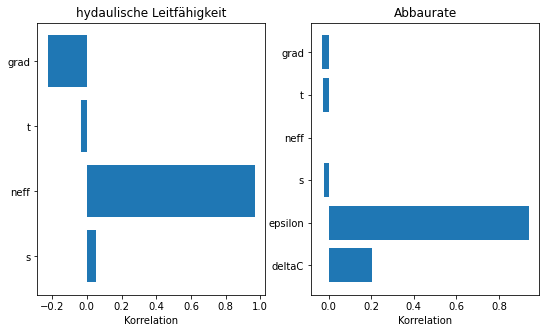

In [7]:
# [3] 
import matplotlib.pyplot as plt

labels = ['deltaC', 'epsilon', 's', 'neff', 't', 'grad']
plot_bio = correlation.iloc[0,2:len(correlation)]

labels_kf = ['s', 'neff', 't', 'grad']
plot_kf = correlation.iloc[1,4:len(correlation)]

fig = plt.figure(1, figsize=(9, 5))

ax = fig.add_subplot(1,2,1)
plt.barh(labels_kf, width=plot_kf)
plt.xlabel('Korrelation')
plt.title ('hydaulische Leitfähigkeit')

ax1 = fig.add_subplot(1,2,2)
plt.barh(labels, width=plot_bio)
plt.xlabel('Korrelation')
plt.title ('Abbaurate')
plt.show()


### Aufgabe 2: Sobol Indizes

Für fortgeschrittene Sensitivitätsanalysen gibt es in Python das Package `SALib` (https://salib.readthedocs.io/en/latest/index.html), in dem viele gängige Methoden (z.B. Morris Method, Sobol Indices) und die benötigten Sampling-Strategien implementiert sind. Um dieses benutzen zu können müsst ihr es zuerst in euer Python-Environment installieren. 

Zur Bestimmung der Sobol Indizes werden zwei Algorithmen aus SALib benötigt: Mit `SALib.sample.saltelli.sample()` erfolgt das Generieren der Input-Wertematrix, danach werden mit diesen Inputs die Modelloutputs erzeugt, und mit `SALib.analyze.sobol.analyze()` erfolgt schließlich die Bestimmung der Sobol-Indizes. 

`SALib.sample.saltelli.sample()` benötigt als Input-Argument ein Python Dictionary mit der folgenden Angaben: 

'{'num_vars': Anzahl_unsichere_Parameter, 'names': [Name1, Name2, ...], 'bounds':[[min1, max1], [min2, max2], ...]}'

Definiert nun zuerst ein Python Dictionary mit den entsprechenden Angaben zu dem analytischen Abbaumodell aus den letzten Übungen, und erzeugt Euch dann mit `SALib.sample.saltelli.sample()` einen Inputdatensatz für das analytische Modell. 

Inspiziert anschließend den generierten Inputdatensatz um die  Sampling Strategie nachzuvollziehen. 

In [ ]:
# [4] 
# benötigtes Package importieren
from SALib.sample.saltelli import sample

# Dictionary erzeugen
problem = {
    'num_vars': 6,
    'names': ['deltaC', 'epsilon', 's', 'neff', 't', 'grad'],
    'bounds': [[3.8, 4.8],
               [-3.2, -1.1],
               [415, 423],
               [0.12, 0.3],
               [3e8, 3.3e8],
               [1.3e-3, 1.6e-3]]
}

# Inputmatrix erzeugen
X = sample(problem, 1000)

# Datensatz inspizieren
print(X)

Venwendet nun die eben erzeugten Modell-Inputs, um mit einer `for` Schleife und dem analytischen Modell der letzten Übungen die entsprechenden Outputs (hydraulische Leitfähigkeit und biologische Abbaurate) zu berechnen (siehe Übung 8 Monte Carlo Methoden). 

In [ ]:
# [5]
# Packages laden
from SALib.analyze.sobol import analyze
import numpy as np

# Anzahl der Modelldurchläufe sowie leere Arrays für Outputs definieren 
n = len(X)
kf =np.zeros(n)
lambda_rate = np.zeros(n)

# mit for-Schleife und analytischem Modell Outputs erzeugen
for i in range(n):
    kf[i] = (X[i, 2]*X[i, 3])/(X[i, 4]*X[i, 5])
    lambda_rate[i] = -(X[i, 0]*kf[i]*X[i, 5])/(X[i, 1]*X[i, 2]*X[i, 3])

Y = lambda_rate*3600*24*365 # to get values as [1/a]

Als Inputs für `SALib.analyze.sobol.analyze()` sind das Eingangs-Dictionary, sowie die Modell-Ouputs erforderlich. Mit der zusätzlichen Angabe von "print_to_console=True" könnt Ihr Euch die Indizes direkt ausgeben lassen. 

Schaut Euch die Werte an, und vergleicht sie mit den Ergebnissen der Morris Method und Contribution-to-Variance Analyse. 

In [ ]:
#[6]
# Packages laden
from SALib.analyze.sobol import analyze

# Sobol Indizes berechnen
Sobol = analyze(problem, Y, print_to_console=True)

Um die Effekte Erster Ordnung und Totalen Effekte zu vergleichen, visualisiert diese abschließend in einer Graphik. Vergleicht dabei die verschiedenen Effekte in Bezug auf die einzelnen Parameter und interpretiert diese. 

In [ ]:
#[7]
import matplotlib.pyplot as plt

labels = ['deltaC', 'epsilon', 's', 'neff', 't', 'grad']

fig = plt.figure(1, figsize=(9, 5))

ax = fig.add_subplot(1,2,1)
plt.barh(labels, width=Sobol['S1'])
plt.xlabel('Effekte Erster Ordnung')
plt.title ('Effekte Erster Ordnung')

ax1 = fig.add_subplot(1,2,2)
plt.barh(labels, width=Sobol['ST'])
plt.xlabel('Totale Effekte')
plt.title ('Totale Effekte')
plt.show()

## Ende

### Referenzen: 

Würth et al. (2021): Quantifying biodegradation rate constants of o-xylene by combining compound-specific isotope analysis and groundwater dating. Journal of Contaminant Hydrology, 238, 103757